In [10]:
from pprint import pformat
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import json
import IPython

In [11]:
from pathlib import Path
import random

In [12]:
def read_list(file_path='../data/soundAttGAN/koreancorpus.xlsx', data_path='../data/soundAttGAN', hub=None):
    
    file_list = []
    
    if hub:
        logging.info(f'reading hub data from {hub}')
        p = Path(hub)
        for each in p.iterdir():
            for wav in each.glob('*.wav'):
                file_list.append({
                    "fileName": str(wav)
                })
        

    else:
        logging.info(f'reading lab data from {data_path} & {file_path}')

        info_file = pd.read_excel(file_path, sheet_name="Sheet1")

        def _append_to_file_list(row, file_list):
            """data_path 읽어서 file_list 에 넣음,

            :param row: 엑셀
            :param file_list:
            :return: None
            """
            file_name = f"{data_path}/{int(row['fileName'])}_{int(row['suffix'])}.wav"

            text = row["text"]

            file_list.append({
                    "fileName": file_name,
                    "text": text
            })

        info_file.apply(partial(_append_to_file_list, file_list=file_list), axis=1)

    return file_list

In [83]:
import json
import random
from functools import partial
from pathlib import Path
from pprint import pformat
import pandas as pd
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# from env import *

import logging

logger = logging.getLogger()
logger.setLevel("DEBUG")


def load_config(file):
    with open(file) as f:
        data = json.load(f)
    return data


def read_list(file_path='../data/soundAttGAN/koreancorpus.xlsx', data_path='../data/soundAttGAN', hub=None):
    file_list = []

    if hub:
        logging.info(f'reading hub data from {hub}')
        p = Path(hub)
        for each in p.iterdir():
            for wav in each.glob('*.wav'):
                file_list.append({
                    "fileName": str(wav)
                })


    else:
        logging.info(f'reading lab data from {data_path} & {file_path}')

        info_file = pd.read_excel(file_path, sheet_name="Sheet1")

        def _append_to_file_list(row, file_list):
            """data_path 읽어서 file_list 에 넣음,

            :param row: 엑셀
            :param file_list:
            :return: None
            """
            file_name = f"{data_path}/{int(row['fileName'])}_{int(row['suffix'])}.wav"

            text = row["text"]

            file_list.append({
                "fileName": file_name,
                "text": text
            })

        info_file.apply(partial(_append_to_file_list, file_list=file_list), axis=1)

    return file_list


class DataLoader():

    def __init__(self, config='./config.json'):
        logging.info(f'DataLoader initializing')
        logging.info(f'configuration setting from {config}')
        self.config = load_config(config)
        logging.info(pformat(self.config))

        self.data_lab = None
        self.data_hub = None

        self.sr = self.config['sr_hub']
        self.hop_length = self.config['hop_length']
        self.n_fft = self.config['n_fft']
        self.n_mels = self.config['n_mels']
        self.n_cnns = self.config['n_cnns']

        self.build()

    #         logging.info(f'frame rate: {}')

    def build(self):
        self.data_lab = read_list()
        self.data_hub = read_list(hub=self.config['data_hub'])

    def train_generator(self, data, norm=True):
        """audio Generator

        :return: y, sr
        """
        if data == 'lab':
            files = self.data_lab
            raise NotImplementedError
        elif data == 'hub':
            files = self.data_hub
        else:
            raise TypeError

        for each in files:
            file_name = each['fileName']
            _y, _sr = librosa.load(file_name, sr=self.sr)

            if norm:
                div = max(_y.max(), abs(_y.min()))
                _y = _y * (1. / div)

            _y = self._melspectrogram(_y)

            if _y.shape[1] < 128 or _y.shape[1] > self.n_mels * self.n_cnns:
                # logging.debug(f'{_y.shape[0]} < 2.0 sec, file_name: {file_name}')
                continue
            
            _y = self._extend_timestep(_y)

            #             if stft:
            #                 # D:np.ndarray [shape=(1 + n_fft/2, t), dtype=dtype]
            #                 _y = self.stft(_y)
            #                 _y = np.expand_dims(_y, axis=-1)

            yield _y
    def _extend_timestep(self, y):
        place = np.zeros(shape=[self.n_mels, self.n_mels * self.n_cnns])
        length = y.shape[1]
        n_fit = length // self.n_mels

        for i in range(n_fit):
            place[:, i*self.n_mels:(i+1)*self.n_mels] = y[:, i*self.n_mels:(i+1)*self.n_mels]
        place[:, n_fit*self.n_mels:length] = y[:, n_fit*self.n_mels:length]
        return place

    #     def stft(self, y, db=False, abs=False):
    #         """short time fourier transform"""

    #         # [shape=(1 + n_fft/2, t), dtype=dtype]
    #         y = librosa.stft(y=y,
    #                          n_fft=self.config['n_fft'],
    #                          window=self.config['window'],
    #                          hop_length=self.config['hop_length'],
    #                         dtype=np.float32)
    #         print(y)
    #         if abs:
    #             y = np.abs(y)

    #         if db:
    #             y = librosa.amplitude_to_db(y, ref=np.max)

    #         return y

    def _melspectrogram(self, y):
        """Compute a mel-scaled spectrogram"""
        # [shape=(n_mels, t)]
        return librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.config['n_mels'], n_fft=self.config['n_fft'],
                                              S=None, hop_length=self.config['hop_length'], win_length=None,
                                              window=self.config['window'], center=True, pad_mode='reflect', power=2.0)

    def _mel_to_audio(self, mel):
        return librosa.feature.inverse.mel_to_audio(mel, sr=self.config['sr_hub'], n_fft=self.config['n_fft'],
                                                    hop_length=self.config['hop_length'])

    #     def istft(self, stft_matrix):
    #         return librosa.istft(stft_matrix=stft_matrix, hop_length=self.config['hop_length'])

    def _power_to_db(self, s):
        return librosa.power_to_db(s, ref=np.max)

    def specshow(self, y, mel=True):
        """plot spectrogram

        :param y:
        :return: axis
        """
        if mel:
            y = self._power_to_db(y)
            librosa.display.specshow(y, y_axis='mel', x_axis='time')
            plt.title('Mel spectrogram')
        else:
            #             y = librosa.amplitude_to_db(y, ref=np.max)
            raise NotImplementedError
            librosa.display.specshow(y, hop_length=self.config['hop_length'],
                                     y_axis='log', x_axis='time')
            plt.title('Power spectrogram')

        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    def random_audio(self, path=None, mel_to_audio=False, specshow=True):

        if path:
            raise NotImplementedError
            y, sr = librosa.load(path)

        else:
            y, sr = librosa.load(random.choice(self.data_hub)['fileName'], sr=self.config['sr_hub'])

        if mel_to_audio:
            y = self._melspectrogram(y)
            self.specshow(y, mel=True)
            y = self._mel_to_audio(y)
        else:
            #             self.specshow(y, mel=False)
            pass

        return y, sr

    def test_train_generator(self):
        """

        :return: audio
        """
        it = iter(self.train_generator(data='hub'))
        r_number = random.randint(0, 100)
        for _ in range(r_number):
            _y = next(it)
        return self._mel_to_audio(_y)

dl = DataLoader()

INFO:root:DataLoader initializing
INFO:root:configuration setting from ./config.json
INFO:root:{'data_hub': '../data/KsponSpeech_01',
 'data_lab': '../data/soundAttGAN',
 'data_lab_xlsx': '../data/soundAttGAN/koreancorpus.xlsx',
 'hop_length': 256,
 'n_cnns': 4,
 'n_fft': 512,
 'n_mels': 128,
 'sr_hub': 16000,
 'sr_lab': 22050,
 'window': 'hann'}
INFO:root:reading lab data from ../data/soundAttGAN & ../data/soundAttGAN/koreancorpus.xlsx
INFO:root:reading hub data from ../data/KsponSpeech_01


In [84]:
it = dl.train_generator('hub')

In [85]:
data = next(it)
data.shape

(128, 512)

In [89]:
data[:, 0:128]

array([[2.59373686e-03, 4.45694849e-03, 7.13444129e-03, ...,
        1.26057183e-02, 9.01978090e-03, 2.06005853e-02],
       [1.89102802e-03, 3.17862653e-03, 6.55863713e-03, ...,
        4.17343751e-02, 1.55842593e-02, 2.35544909e-02],
       [1.18468748e-03, 1.89000927e-03, 6.05054758e-03, ...,
        7.27087557e-02, 2.26518922e-02, 2.69682501e-02],
       ...,
       [1.83744953e-06, 2.19678509e-06, 1.19844583e-06, ...,
        4.92766389e-07, 9.72935482e-07, 4.01288219e-07],
       [9.38411290e-07, 4.45445323e-07, 5.95303447e-07, ...,
        5.95807535e-07, 8.61052513e-07, 5.43486635e-07],
       [1.84310835e-07, 2.51836980e-07, 2.11809336e-07, ...,
        4.31042366e-07, 5.48513015e-07, 2.59171941e-07]])

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0008b32250>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0008b32250>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STI

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'NanumGothicCoding' (NanumGothic_Coding_Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizeTwoSym-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-RI.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (Liberatio

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal bold condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Medium.ttc) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'UnDotum' (UnDotu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TakaoPGothic' (TakaoPGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizeOneSym-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'UnPilgi' (UnPilgi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral-Italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Laksaman' (Laksaman-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (Padauk-book.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizeFourSym-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstQurn' (KacstQurn.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-DemiLight.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Punjabi' (Lohit-Punjabi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-RI.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/mhlee/miniconda3/envs/jupyter/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


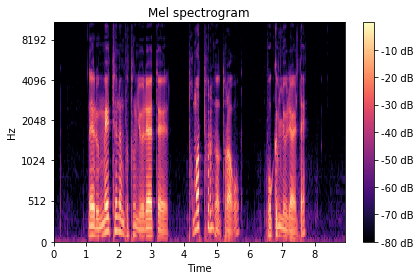

(array([0.0004794 , 0.00043626, 0.00047483, ..., 0.00035436, 0.00035769,
        0.00039646], dtype=float32), 16000)

In [91]:
dl.random_audio(mel_to_audio=True)

In [75]:
_place = np.zeros(shape=[dl.n_mels, dl.n_mels * dl.n_cnns])
_place.shape

(128, 512)

In [76]:
def _extend_timestep(y):
    place = np.zeros(shape=[self..n_mels, self.n_mels * self.n_cnns])
    length = y.shape[1]
    n_fit = length // self.n_mels

    for i in range(n_fit):
        place[:, i*self.n_mels:(i+1)*self.n_mels] = y[:, i*self.n_mels:(i+1)*self.n_mels]
    place[:, n_fit*self.n_mels:length] = y[:, n_fit*self.n_mels:length]
    return place

In [77]:
_place.shape

(128, 512)

In [78]:
_place[:, 0:data_length] == data[:, 0:data_length]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [16]:
y, sr = dl.random_audio(mel_to_audio=False)
IPython.display.Audio(y, rate=sr)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f29657d9b90>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f29657d9b90>
DEBUG:matplotlib.colorbar:Setting pcolormesh


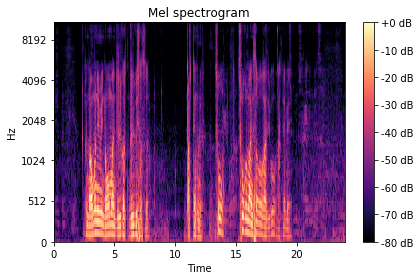

In [544]:
y, sr = dl.random_audio(mel_to_audio=True)
IPython.display.Audio(y, rate=sr)

In [462]:
mel = dl._melspectrogram(y, sr)
mel.shape
# print(mel)

(128, 929)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f296518c210>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f296518c210>
DEBUG:matplotlib.colorbar:Setting pcolormesh


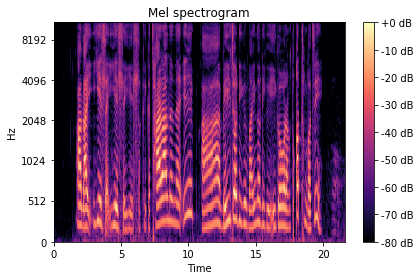

In [543]:
dl.specshow(mel, mel=True)